In [2]:
# # We recall the idea is we want to get
# max(sum(1-si*sj)) = max(sum(si*sj)) + const
# remember we can Hamiltonian si -> Zi
# max(Zi*Zj)
# Cost Hamiltonian: C = sum(Zi*Zj)

# the full QAOA is just bunch of exp(B)exp(C)H^n|0>
# we need cost operator 
# we need mixer operator





In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

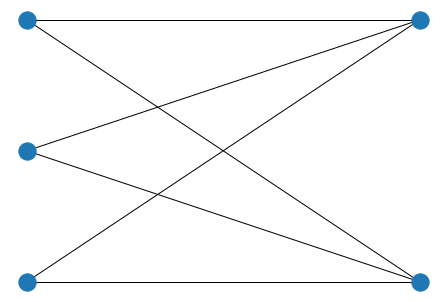

In [4]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

In [5]:
def append_zz_term(qc, q1, q2, gamma):
    # there is a flavor of entanglement
    # when we apply CNOT gates and disconnect them
    qc.cx(q1, q2) # do control-NOT
    qc.rz(2*gamma, q2) # rotate by gamma
    qc.cx(q1,q2) # sandwich with another control-NOT
    # also known as disconnect, but the entangelement 
    # effect persists even after this operator
    
# okay here we are building cost operator
def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        # if there is an edge between nodes i and j
        # we then need to append X? operator HZH?
        # interesting how we are using CX gates to indicate edge
        # I saw this idea, but still don't understand
        append_zz_term(qc, i, j, gamma)
        qc.barrier()
    return qc


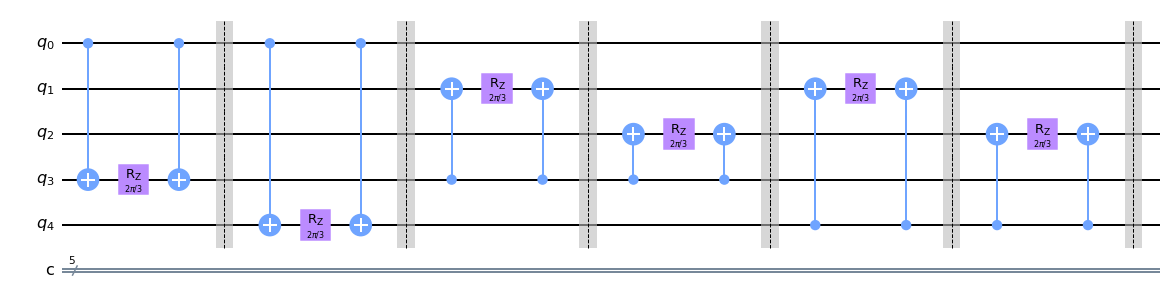

In [6]:
qc = get_cost_operator_circuit(G, np.pi/3) # here gamma is just some random
qc.draw('mpl')

In [7]:
# work on mixer operator now
# there are just exp(X)
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)
    
def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    for n in G.nodes():
        # similar idea and symmteric code to the cost function
        append_x_term(qc, n, beta)
    return qc

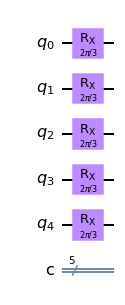

In [8]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw('mpl')

In [9]:
# basically we are almost done, just combine everything

def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    # first, apply a layer of Hadamards go get them all superimposed?
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G, gamma[i])
        qc += get_mixer_operator_circuit(G, beta[i])
    
    # finally, do no forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    # don't really need to measure for statevector simulator?
    return qc


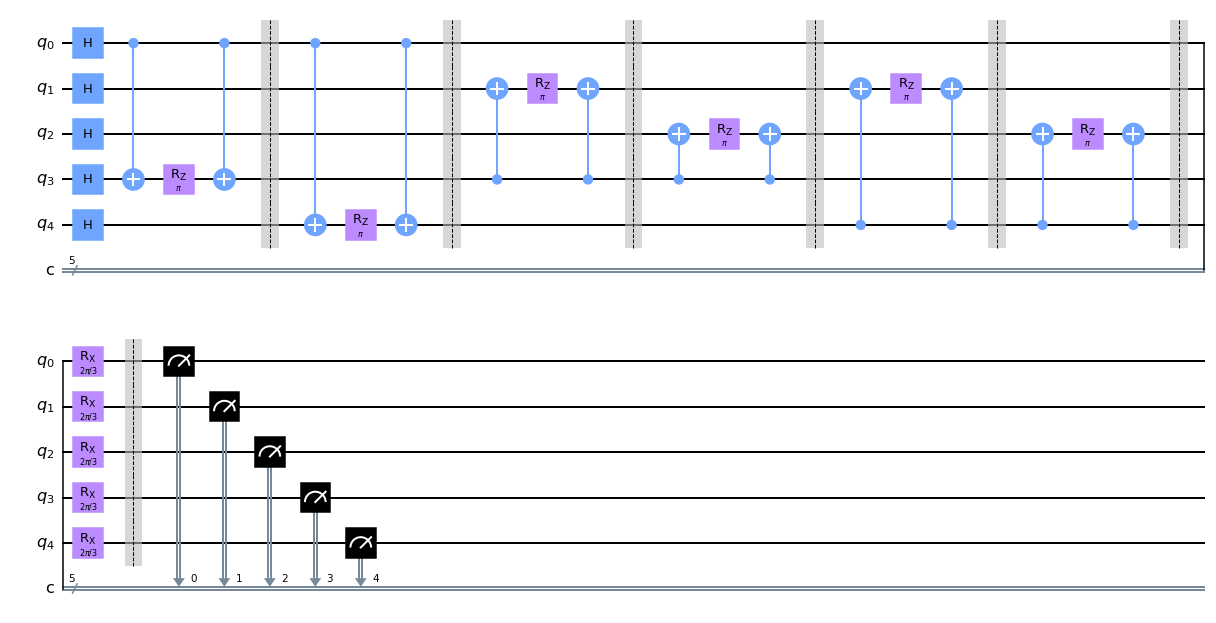

In [10]:
qc = get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
qc.draw('mpl')
# quite simple i feel like compared to some other stuff I did

In [11]:
# might need to invert samples
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items() }


{'00000': 25, '10000': 27, '00001': 24, '10001': 31, '01001': 35, '11001': 28, '00101': 21, '10101': 38, '01101': 36, '11101': 17, '00011': 24, '10011': 28, '01011': 33, '11011': 38, '00111': 41, '10111': 31, '01111': 44, '11111': 40, '01000': 32, '11000': 42, '00100': 30, '10100': 43, '01100': 33, '11100': 25, '00010': 40, '10010': 34, '01010': 33, '11010': 25, '00110': 27, '10110': 21, '01110': 42, '11110': 36}


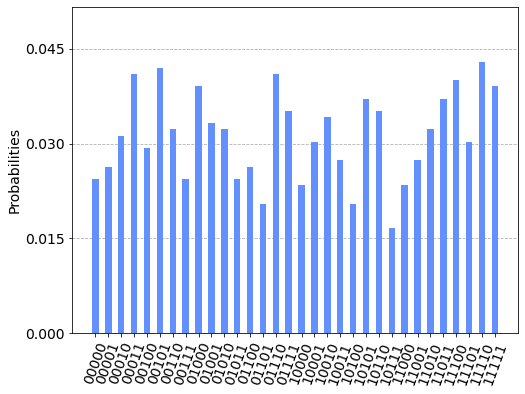

In [16]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))
plot_histogram(result.get_counts(), figsize = (8, 6), bar_labels = False)


In [17]:
# okay how good are these results?
# we must compute cost fucntion and see if it is good?
def maxcut_obj(x, G):
    cut = 0
    for i, j in G.edges():
        # if they are not the same color we say the edge is cut between them
        # x is a set of colors, binary, also the answer? best probabilistic?
        if x[i] != x[j]:
            # the edge is cut
            # it is kinda weird to add negatives, but ok
            cut -= 1
    return cut

maxcut_obj('00011', G) 

-6

In [18]:
# we also want energy?
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        # this will give some negative number
        obj_for_meas = maxcut_obj(meas, G)
        # now we sum over all those negative numbers?
        energy += obj_for_meas * meas_count
        # and get total counts energy along the way
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)
# okay we got some result now?

-2.970703125

In [19]:
# QAOA is a variational algorithm, so we are using classical optimizer
def get_black_box_objective(G, p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        # for what, angles? but why?
        # p is depth?
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    # weirdly f works? without a parameter even though it needs theta?
    return f

In [20]:
# p in the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500?
res_sample = minimize(obj, init_point, method = 'COBYLA', options={'maxiter':2500, 'disp':True})
res_sample
# we terminated 134 so not at 2500
# we already got -5.29785 as our first guess which is close to -6?

     fun: -5.2978515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 134
  status: 1
 success: True
       x: array([1.83749394, 2.1345936 , 1.9319531 , 2.09862998, 0.347631  ,
       2.04618358, 6.11249139, 2.31785137, 3.56479392, 5.87260613])

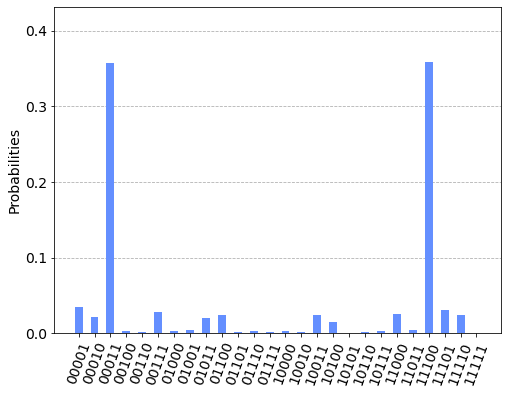

In [22]:
# amazing
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:]) 
counts = invert_counts(execute(qc, backend).result().get_counts())
counts
plot_histogram(counts, figsize = (8, 6), bar_labels = False)

<BarContainer object of 5 artists>

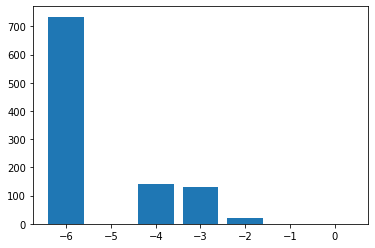

In [23]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k, G)] += v
    
x, y = zip(*energies.items())
plt.bar(x,y)

Best string: 00011 with cut: 6


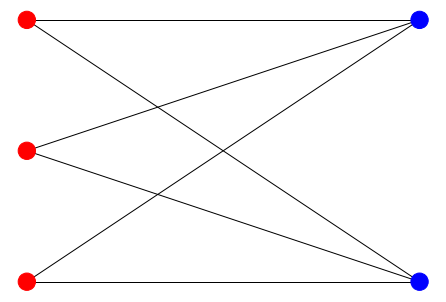

In [25]:
# get the best solution
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G, node_color = colors, pos = nx.bipartite_layout(G, [0,1,2]))

In [26]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
sv = execute(qc, backend = Aer.get_backend('statevector_simulator')).result().get_statevector()
sv

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [37]:
# Endianness conversion tools from github

def state_num2str(basis_state_as_num, nqubits):
    # i see these are binary conversion string to num
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    # go backwords
    new_str = basis_state_as_str[::-1] 
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)
    
    adjusted_state = np.zeros(2**nqubits, dtype = complex)
    for basis_state in range(2**nqubits):
        # the statevector is reversed here to look better?
        adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

In [38]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    qc.h(range(N))
    for i in range(p):
        qc += get_cost_operator_circuit(G, gamma[i])
        qc += get_mixer_operator_circuit(G, beta[i])
    # no measurement for sv
    return qc



In [44]:
# we also need amplitudes for sv
def state_to_ampl_counts(vec, eps=1e-15):
    """ Converts a statevector to a dictionary
    of bitstring and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid sstatevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        # basically a dictionary to get binary string to the amplitude
        # we could use them to plot?
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
        
            
    return counts

In [45]:
backend = Aer.get_backend('statevector_simulator')
qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
state_to_ampl_counts(sv)

{'00000': (0.014279499254842742+0.011623320789211225j),
 '00001': (0.134382015890513-0.09405829764019874j),
 '00010': (0.13438201589051307-0.09405829764019878j),
 '00011': (-0.01602140096028898-0.6036236563655749j),
 '00100': (-0.05350133952544349+0.006060075992361393j),
 '00101': (-0.03628471735810235-0.010367992306133656j),
 '00110': (-0.03628471735810244-0.010367992306133673j),
 '00111': (-0.06213658117215933+0.13217051841932279j),
 '01000': (-0.05350133952544355+0.0060600759923614385j),
 '01001': (-0.036284717358102375-0.010367992306133646j),
 '01010': (-0.03628471735810241-0.01036799230613367j),
 '01011': (-0.06213658117215937+0.13217051841932265j),
 '01100': (-0.06213658117215923+0.1321705184193228j),
 '01101': (-0.03628471735810236-0.010367992306133582j),
 '01110': (-0.03628471735810238-0.01036799230613358j),
 '01111': (-0.05350133952544352+0.0060600759923614j),
 '10000': (-0.05350133952544353+0.006060075992361286j),
 '10001': (-0.036284717358102424-0.010367992306133705j),
 '100

In [49]:
def compute_maxcut_energy_sv(sv, G):
    """Compute objectirv from statevector
    For large number of qubits, this is slow.
    """
    counts = state_to_ampl_counts(sv)
    return sum(maxcut_obj(np.array([int(x) for x in k]), G) * (np.abs(v)**2) for k, v in counts.items())

compute_maxcut_energy_sv(sv, G)
# looks like the correct energy, but it is weird cause I don't understand

-5.296260485608108

In [60]:
def get_black_box_objective_sv(G, p):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G, beta, gamma)
        sv = execute(qc, backend).result().get_statevector()
        # return the energy
        return compute_maxcut_energy_sv(get_adjusted_state(sv), G)
    return f

In [61]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# we are going to limit iterations to 2500
res_sv = minimize(obj, init_point, method = 'COBYLA', options = {'maxiter':2500, 'disp':True})
res_sv


     fun: -5.9462771695619825
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2500
  status: 2
 success: False
       x: array([2.18753782, 2.0168998 , 1.98610691, 1.82258811, 0.55144154,
       2.26879831, 6.08783415, 2.38180135, 3.75721464, 6.0385444 ])

In [62]:
print(f"Best energy with sampled: {res_sample['fun']:.2f}, with full state vector: {res_sv['fun']:.2f}")


Best energy with sampled: -5.30, with full state vector: -5.95


In [64]:
# simulating qasm and statevector is not the same
print(f"Angles found with sampled: beta = {res_sample['x'][:p]}, gamma={res_sample['x'][p:]}")
print(f"Angled found with full state: beta = {res_sv['x'][:p]}, gamma={res_sv['x'][p:]}")


Angles found with sampled: beta = [1.83749394 2.1345936  1.9319531  2.09862998 0.347631  ], gamma=[2.04618358 6.11249139 2.31785137 3.56479392 5.87260613]
Angled found with full state: beta = [2.18753782 2.0168998  1.98610691 1.82258811 0.55144154], gamma=[2.26879831 6.08783415 2.38180135 3.75721464 6.0385444 ]


In [65]:
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = res_sample['x']
res_sv2 = minimize(obj, init_point, method = 'COBYLA', options = {'maxiter':50, 'disp':True, 'rhobel':0.001})
res_sv2

/home/note/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:623: OptimizeWarning: Unknown solver options: rhobel
  return _minimize_cobyla(fun, x0, args, constraints, **options)


     fun: -5.585249743470689
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 50
  status: 2
 success: False
       x: array([1.89127932, 2.13632066, 1.99145435, 1.99940251, 0.42844346,
       2.04860869, 6.15119958, 2.34549801, 3.64043741, 5.82400365])

In [66]:
# steps?
"""
1. Choose a problem class (maxcut) and a problem instance (graph)
2. Come up with a general Hamiltonian for the problem class
3. Build specific Hamiltonian for the problem instance
4. From the Hamiltonian, construct QAOA circuit
5. Wrap QAOA circuit in a black box function
6. Optimize QAOA parameters
7.Get solution by running QAOA circuit with optimal parameters"""

'\n1. Choose a problem class (maxcut) and a problem instance (graph)\n2. Come up with a general Hamiltonian for the problem class\n3. Build specific Hamiltonian for the problem instance\n4. From the Hamiltonian, construct QAOA circuit\n5. Wrap QAOA circuit in a black box function\n6. Optimize QAOA parameters\n7.Get solution by running QAOA circuit with optimal parameters'

In [67]:
def get_cost_operator(weight_matrix):
    """ Generate Hamiltonian for the max-cut problem of a graph.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        WeightedpauliOperator: operator for the Hamiltonian
        float: a constant shift for the obj function"""
    num_nodes = weight_matrix.shape[0]
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype = np.bool)
                z_p = np.zeros(num_nodes, dtype = np.bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([0.5 * weight_matrix[i,j], Pauli(z_p, x_p)])
                shift -= 0.5 * weight_matrix[i, j]
    return WeightedPauliOperator(paulis=pauli_list), shift

In [70]:
w = nx.adjacency_matrix(G, nodelist = range(G.number_of_nodes()))
C, offset = get_cost_operator(w)
print(C.print_details())

IZIIZ	(0.5+0j)
IZIZI	(0.5+0j)
IZZII	(0.5+0j)
ZIIIZ	(0.5+0j)
ZIIZI	(0.5+0j)
ZIZII	(0.5+0j)



In [85]:
# check if hamiltonian is correct one?
ee = NumPyEigensolver(C, k=1) # k = 1 means lowerst eignevalue and eigenvector
result = ee.run()
result['eigenstates'][0]

VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)

In [88]:
from qiskit.optimization.applications.ising.common import sample_most_likely
print(f"Solution: {sample_most_likely(result['eigenstates'][0])} with cut: {result['eigenvalues']+offset}")

Solution: [0 0 0 1 1] with cut: [-6.+0.j]


In [89]:
I = np.eye(2,2)
Z = np.array([[1.,0.], [0.,-1.]])

Z0Z3 = np.kron(np.kron(np.kron(np.kron(Z,I),I),Z),I)
Z0Z4 = np.kron(np.kron(np.kron(np.kron(Z,I),I),I),Z)
Z1Z3 = np.kron(np.kron(np.kron(np.kron(I,Z),I),Z),I)
Z1Z4 = np.kron(np.kron(np.kron(np.kron(I,Z),I),I),Z)
Z2Z3 = np.kron(np.kron(np.kron(np.kron(I,I),Z),Z),I)
Z2Z4 = np.kron(np.kron(np.kron(np.kron(I,I),Z),I),Z)

C_numpy = 0.5 * (Z0Z3 + Z0Z4 + Z1Z3 + Z1Z4 + Z2Z3 + Z2Z4)

In [93]:
eigval, eigvec = np.linalg.eig(C_numpy)
idx = eigval.argsort()
lowest_eigval = eigval[idx][0]
lowest_eigvec = eigvec[idx][0]

print(f"Solution: {sample_most_likely(lowest_eigvec)} with cut: {lowest_eigval+offset}")

Solution: [1. 1. 0. 0. 0.] with cut: -6.0


In [94]:
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm

p = 5
var_form = QAOAVarForm(C.to_opflow(), p)

{'00000': 63, '00001': 11, '10001': 45, '10010': 38, '10011': 44, '10100': 38, '10101': 45, '10110': 36, '10111': 2, '11000': 35, '11001': 31, '11010': 55, '11011': 12, '11100': 36, '11101': 12, '11110': 8, '11111': 55, '00010': 10, '00011': 47, '00100': 8, '00101': 44, '00110': 39, '00111': 29, '01000': 1, '01001': 44, '01010': 52, '01011': 43, '01100': 50, '01101': 52, '01110': 39}


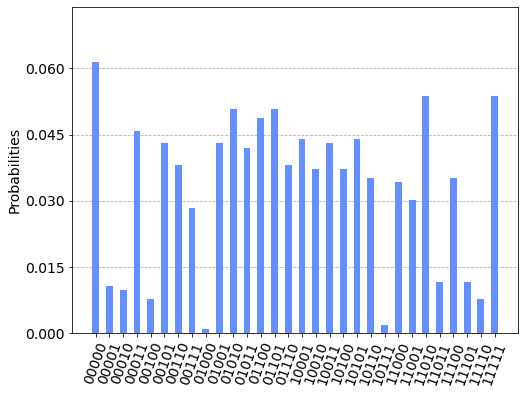

In [97]:
N = G.number_of_nodes()
lb = np.zeros(2*p)
ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
random_point = np.random.uniform(lb, ub, 2*p)

qc = var_form.construct_circuit(random_point)

if not qc.cregs:
    c = ClassicalRegister(N, name='c')
    qc.add_register(c)
    
qc.measure(qc.qregs[0], qc.cregs[0])

backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend).result().get_counts()
print(counts)
plot_histogram(counts, figsize = (8, 6), bar_labels = False)

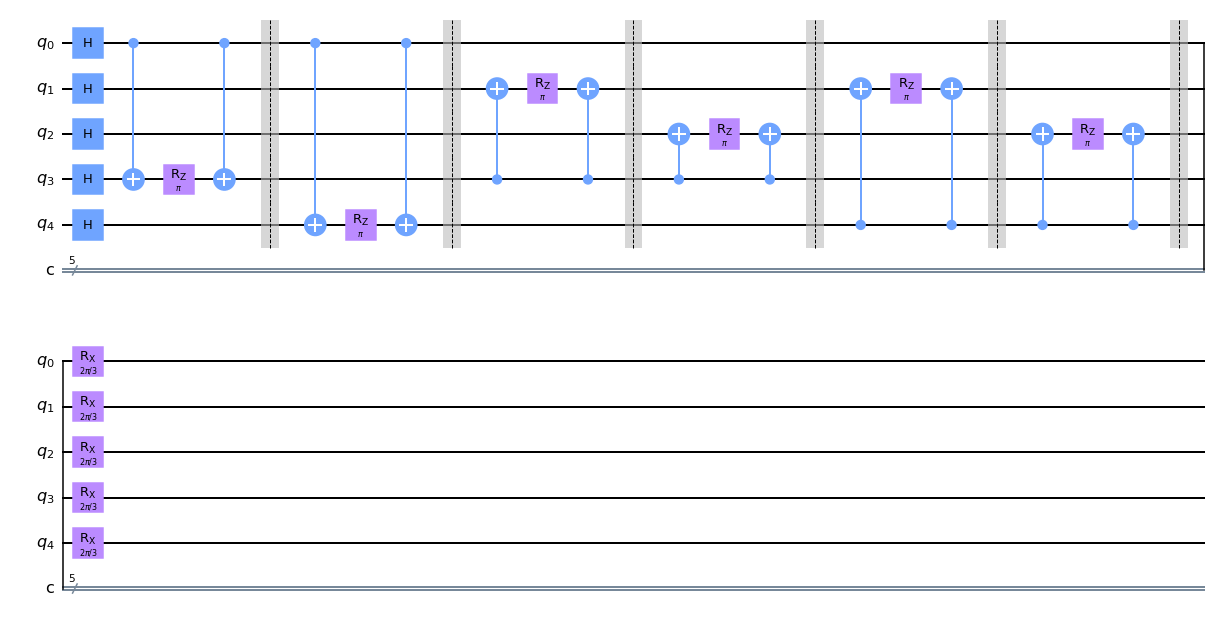

In [98]:
qc_our = get_qaoa_circuit_sv(G, [np.pi/3], [np.pi/2])
qc_our.draw('mpl')

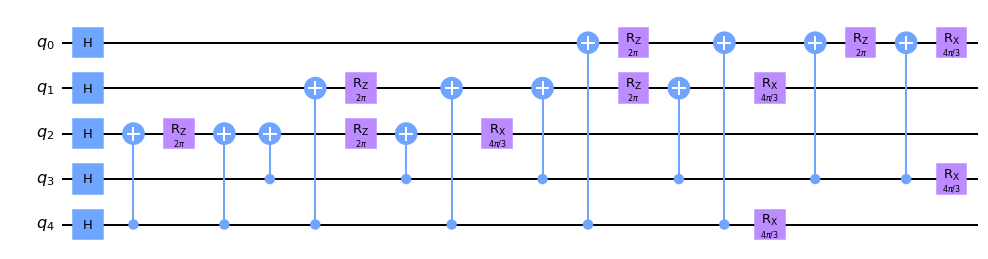

In [101]:
from qiskit.compiler import transpile
var_form_qiskit = QAOAVarForm(C.to_opflow(), 1)
qc_qiskit = var_form_qiskit.construct_circuit([2*np.pi, 2*np.pi/3])
circuit_qiskit = transpile(qc_qiskit, optimization_level = 0, basis_gates=['rz', 'rx', 'h', 'cx'])
circuit_qiskit.draw('mpl')

In [103]:
def equal_up_to_global_phase(sv1, sv2):
    nnz = np.nonzero((sv1 != 0) & (sv2 != 0))
    phase = sv1[nnz] / sv2[nnz]
    return np.all(np.isclose(phase, phase[0]))

# to get rid of numerial erros
def remove_vals_smaller_than_eps(a, eps=10*np.finfo(np.float).eps):
    a.real[abs(a.real) < eps] = 0.0
    a.imag[abs(a.imag) < eps] = 0.0
    return a

backend = Aer.get_backend("unitary_simulator")
unitary_our = remove_vals_smaller_than_eps(execute(qc_our, backend=backend).result().get_unitary())
unitary_qiskit = remove_vals_smaller_than_eps(execute(qc_qiskit, backend = backend).result().get_unitary())
print(equal_up_to_global_phase(unitary_our, unitary_qiskit))
# sad

False


In [105]:
print(f"type of C_numpy is {type(C_numpy)}")
from qiskit.aqua.operators import MatrixOperator
C_converted = MatrixOperator(C_numpy)
var_form = QAOAVarForm(C_converted.to_opflow(), p)
var_form

type of C_numpy is <class 'numpy.ndarray'>
